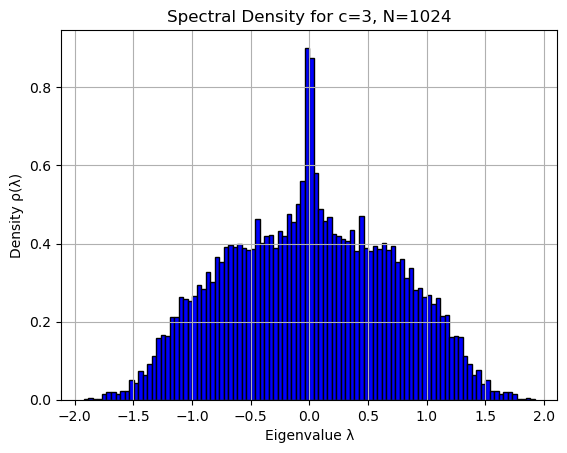

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import eigh

##ex.2.1

#random matrix generator
def random_matrix(N, c): 
    A_adjacency = nx.to_numpy_array(nx.random_regular_graph(c,N))
    J_gaussian = np.random.normal(loc=0, scale=1/np.sqrt(c), size=(N, N))
    J_gaussian = (J_gaussian + J_gaussian.T)/2  # Symmetric
    M = A_adjacency * J_gaussian
    return M

#diagonalization via eigh
def diagonalization_spectrum(matrices):
    eigenvalues = []
    for M in matrices:
        evs = eigh(M, eigvals_only=True)
        eigenvalues.extend(evs)
    return np.array(eigenvalues)


# Parameters
N = 2**10
c = 3

# generate matrices
matrices = [random_matrix(N, c) for _ in range(10)]
eigenvalues = diagonalization_spectrum(matrices)



plt.hist(eigenvalues, bins=100, color='blue',edgecolor='black',density=True)
plt.xlabel("Eigenvalue λ")
plt.ylabel("Density ρ(λ)")
plt.title("Spectral Density for c=3, N=1024")
plt.grid(True)
plt.show()

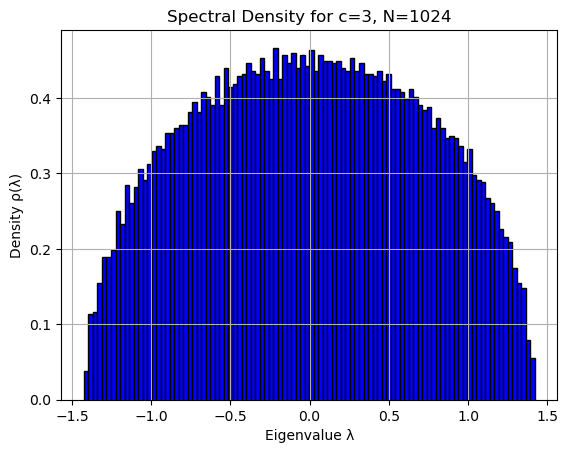

In [18]:
##ex.2.2

#generate random matrix
def fully_connected_matrix(N):
    J_gaussian = np.random.normal(loc=0, scale=1/np.sqrt(N), size=(N, N))
    return (J_gaussian + J_gaussian.T) / 2

#fully connected case
matrices_full = [fully_connected_matrix(N) for _ in range(10)]
eigenvalues_full = diagonalization_spectrum(matrices_full)



plt.hist(eigenvalues_full, bins=100, color='blue',edgecolor='black',density=True)
plt.xlabel("Eigenvalue λ")
plt.ylabel("Density ρ(λ)")
plt.title("Spectral Density for c=3, N=1024")
plt.grid(True)
plt.show()

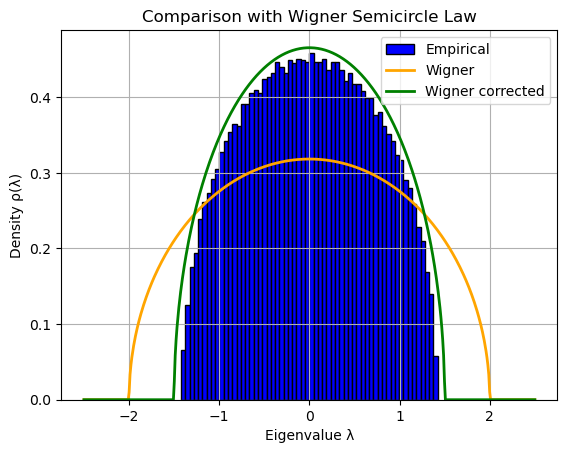

In [28]:
##ex.2.3

#compare with wigner circle
def wigner_semicircle(x):
    return np.where(
        np.abs(x) <= 2,
        np.sqrt(np.maximum(0, 4 - x**2)) / (2 * np.pi),
        0.0
    )

#adjusted circle that is more fitting
def wigner_semicircle_corr(x):
    return np.where(
        np.abs(x) <= 2,
        1.95* np.sqrt(np.maximum(0, 1.5**2 - x**2)) / (2 * np.pi),
        0.0
    )

#  empirical from prevoius part and  theoretical
x_vals = np.linspace(-2.5, 2.5, 500)
plt.hist(eigenvalues_full, bins=60, density=True, label="Empirical", color='blue',edgecolor='black')
plt.plot(x_vals, wigner_semicircle(x_vals), label="Wigner", color='orange', linewidth=2)
plt.plot(x_vals, wigner_semicircle_corr(x_vals), label="Wigner adjusted", color='green', linewidth=2)
plt.xlabel("Eigenvalue λ")
plt.ylabel("Density ρ(λ)")
plt.title("Comparison with Wigner Semicircle Law")
plt.legend()
plt.grid(True)
plt.show()

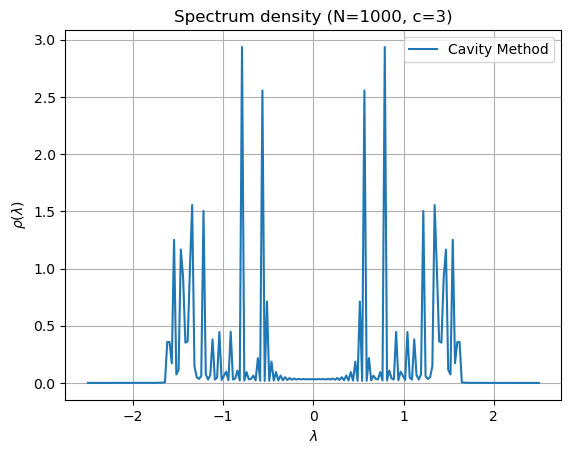

In [2]:
##ex.2.5

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import random
from scipy.sparse import lil_matrix
from networkx.generators.random_graphs import random_regular_graph
import networkx as nx

#generate matrix
def random_matrix_sym(N, c):
    A_adjacency = nx.to_numpy_array(random_regular_graph(c, N))
    return A_adjacency / np.sqrt(c) 

#implement algorithm
def step_cavity(M, lambd, eps=1e-3, max_iter=100):

    ##initializing the resolvent G as matrix M
    size = M.shape[0]
    N=size
    neighbors = [np.nonzero(M[i])[0] for i in range(N)]
    omega = np.full((N, N), lambd - 1j * eps,dtype=np.complex128)

    ##effect of neighbours k != j i.e. cavity message
    for _ in range(max_iter):
        omega_temp = omega.copy()
        for i in range(N):
            for j in neighbors[i]:
                sum_terms = sum(M[i,k]**2 / omega[k,i] for k in neighbors[i] if k != j)
                omega_temp[i,j] = lambd - 1j * eps - sum_terms

        ###precision check
        if np.max(np.abs(omega - omega_temp)) < 1e-5:
            break
        omega = omega_temp

    ##computing the marginals from the messages
    marginal = np.zeros(N,dtype=np.complex128)
    for i in range(N):
        sum_terms = sum(M[i,k]**2 / omega[k,i] for k in neighbors[i])
        marginal[i] = lambd - 1j * eps - sum_terms
    return marginal

def spectral_density(M, eigenvals, eps=1e-3):
    rho_list = []
    for i in eigenvals:
        omega = step_cavity(M, i, eps)
        rho = np.mean(np.imag(1 / omega)) / np.pi
        rho_list.append(rho)
    return np.array(rho_list)

# Parameters
N = 1000
c = 3
M = random_matrix_sym(N, c)
lambdas = np.linspace(-2.5, 2.5, 200)

# Run and plot
rho_vals = spectral_density(M, lambdas)
plt.plot(lambdas, rho_vals, label="Cavity Method")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\rho(\lambda)$")
plt.title(f"Spectrum density (N={N}, c={c})")
plt.legend()
plt.grid()
plt.show()